In [182]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import torch
from torch.types import Tensor
from torchvision.ops import nms

from cvnets.yolov1.net import YOLOv1
from cvnets.yolov1.voc import VOC2012Dataset

S = 7
B = 2
C = 20
imgsz = 448

In [192]:
dataset = VOC2012Dataset("~/Downloads/VOC2012/train_val", imgsz=448, S=7, B=2, split="val", normalize=False)
dataset.eval()

model = YOLOv1(imgsz=imgsz, S=S, B=B, C=C)
model.load_state_dict(torch.load("./checkpoints/yolov1-voc2012.pt", map_location="cpu", weights_only=True))
model = model.eval()

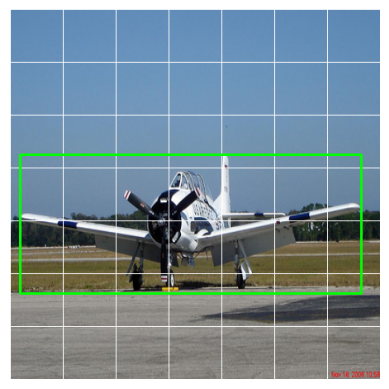

In [193]:
sample = dataset[5]

image = sample.image.permute(1, 2, 0).numpy().astype("uint8")
bboxes = sample.bboxes.numpy()
labels = sample.labels.numpy()

norm = A.Normalize()
image_tensor = norm(image=image)["image"]
image_tensor = torch.as_tensor(image_tensor).permute(2, 0, 1).unsqueeze(0).float()

with torch.inference_mode():
    prediction = model(image_tensor).reshape(1, S, S, 5 * B + C)

cell_size = imgsz // S
for i in range(S):
    for j in range(S):
        cv.rectangle(
            image, (j * cell_size, i * cell_size), ((j + 1) * cell_size, (i + 1) * cell_size), (255, 255, 255), 1
        )

for bbox in bboxes:
    cv.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

plt.imshow(image)
plt.axis("off")
plt.show()

In [194]:
def decode_yolo_output(prediction: Tensor, imgsz: int, S: int, B: int) -> tuple[Tensor, Tensor, Tensor]:
    prediction = prediction.reshape(-1, S, S, 5 * B + C).clamp(0, 1)
    class_scores, class_ids = prediction[..., 5 * B :].max(dim=-1, keepdim=True)

    offset_y, offset_x = torch.meshgrid(torch.arange(S) / S, torch.arange(S) / S, indexing="ij")
    offset_y = offset_y.reshape(1, S, S, 1).repeat(1, 1, 1, B)
    offset_x = offset_x.reshape(1, S, S, 1).repeat(1, 1, 1, B)

    pred_bboxes = prediction[..., : 5 * B].reshape(-1, S, S, B, 5)

    xyxys = torch.stack(
        [
            pred_bboxes[..., 0] / S + offset_x - 0.5 * pred_bboxes[..., 2].square(),
            pred_bboxes[..., 1] / S + offset_y - 0.5 * pred_bboxes[..., 3].square(),
            pred_bboxes[..., 0] / S + offset_x + 0.5 * pred_bboxes[..., 2].square(),
            pred_bboxes[..., 1] / S + offset_y + 0.5 * pred_bboxes[..., 3].square(),
        ],
        dim=-1,
    ).mul(imgsz)
    confs = pred_bboxes[..., 4] * class_scores
    class_ids = class_ids.repeat(1, 1, 1, B)

    xyxys = xyxys.reshape(-1, S * S * B, 4)
    confs = confs.reshape(-1, S * S * B)
    class_ids = class_ids.reshape(-1, S * S * B)

    return xyxys, confs, class_ids


xyxys, confs, labels = decode_yolo_output(prediction, imgsz, S, B)

In [ ]:
conf_mask = confs > 0.03
xyxys = xyxys[conf_mask]
confs = confs[conf_mask]
labels = labels[conf_mask]

keep = nms(xyxys, confs, iou_threshold=0.3)
xyxys = xyxys[keep]
confs = confs[keep]
labels = labels[keep]

img = image.copy()

for bbox in xyxys.squeeze().numpy():
    cv.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)

plt.imshow(img)
plt.axis("off")
plt.show()